# Dual-form ridge and online training of limit cycle from trajectory

Statistics: Error vs targ frequency and number of support states

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, Lasso
import sys

from aux import get_flow
from kernels import make_psi_rand_sgm
from disp import set_plot, colors, quiver

In [2]:
# hparams
D = 2
RX = np.linspace(-1.5, 1.5, 15)
DX = np.mean(np.diff(RX))/2

# base system params
TAU = np.array(.01)
B = np.eye(D)
f_base = lambda x: np.zeros(D)
F_base = lambda x, u: (1/TAU)*(-x + f_base(x) + B@u)

DT = .001

# control directions
C = np.array([
    [1., 0],
    [0,  1],
])  #L   U

# kernel
N = 2000
G = 100
J_PSI = G*np.random.randn(N, D)

psi_name = 'rand_sig'
psi, ker = make_psi_rand_sgm(J_PSI)

def ker_vmap(xs, y):
    k_mat = np.nan*np.zeros((len(xs),))
    for cx, x in enumerate(xs):
        k_mat[cx] = ker(x, y)
    return k_mat

def eval_F(x, u, x_stars, alphas):
    
    df = C@alphas.T@ker_vmap(x_stars, x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj(x_stars, alphas, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F(xs[ct-1, :], us[ct, :], x_stars, alphas)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

def eval_F_primal(x, u, W):
    
    df = C@W.T@psi(x)
    
    return (1/TAU)*(-x + f_base(x) + B@u + df)
    
def smlt_trj_primal(W, x_init, t, us):

    dt = np.mean(np.diff(t))
    xs = np.nan*np.zeros((len(t), D))
    xs[0, :] = x_init

    for ct, t_ in enumerate(t[1:], 1):
        dx = dt*eval_F_primal(xs[ct-1, :], us[ct, :], W)
        xs[ct, :] = xs[ct-1, :] + dx

    return xs

Ridge training

In [3]:
LAM_RIDGE = 1e-10

def train_ridge(data, x_stars):
    """Find alphas using Ridge regression."""
    xs = data[:, :D]
    vs = data[:, D:2*D]
    us = data[:, 2*D:]
    
    # make ys
    f_base_vals = np.array([f_base(x) for x in xs])
    Bus = np.array([B@u for u in us])
    
    ys = TAU*vs + xs - f_base_vals - Bus
    
    # make K
    K = np.array([ker_vmap(xs, x_star) for x_star in x_stars]).T
    
    # find best alphas
    rgr = Ridge(alpha=LAM_RIDGE, fit_intercept=False)
    alphas = rgr.fit(K, ys).coef_.T
    return alphas

Online training

In [4]:
LAM_ONLINE = 1000

T_START = 0.01
IT_START = int(T_START//DT)

T_HOLD = 0.05
IT_HOLD = int(T_HOLD//DT)

T_PAUSE = .01
IT_PAUSE = int(T_PAUSE//DT)

def train_online(x_stars, alphas):
    
    t_learn = np.arange(0, (len(x_stars)+1)*(T_HOLD+T_PAUSE), DT)
    us_learn = np.zeros((len(t_learn), D))
    ls = np.zeros((len(t_learn), D))

    it_temp = IT_START

    for cx_star, (x_star, alpha) in enumerate(zip(x_stars, alphas)):
        us_learn[it_temp:it_temp+IT_HOLD, :] = LAM_ONLINE*x_star
        ls[it_temp+IT_HOLD-1, :] = 1/DT*alpha

        it_temp += (IT_HOLD + IT_PAUSE)

    W = np.zeros((N, D))

    xs = np.nan*np.zeros((len(t_learn), D))
    xs[0, :] = np.zeros(D)

    for ct, t_ in enumerate(t_learn[1:], 1):
        dx = DT*eval_F_primal(xs[ct-1, :], us_learn[ct, :], W)
        xs[ct, :] = xs[ct-1, :] + dx

        # implement plasticity rule
        if np.linalg.norm(ls[ct]) > 0:
            for d in range(D):
                W[:, d] += (DT*ls[ct, d]*psi(xs[ct, :]))
    
    return W

In [5]:
def plot_quivers_primal(eval_F_primal, u=None):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    
    F_primal = lambda x, u: eval_F_primal(x, u, W)
    flow = get_flow(F_primal, RX, u=u)
    
    quiver(axs[0], flow, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$')

    return fig, axs

def plot_quivers(x_stars_all, alphas_all, u=None, arrow_scale=.5):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3), tight_layout=True)
    flow_base = get_flow(F_base, RX, u=u)
    quiver(axs[0], flow_base, RX)
    set_plot(axs[0], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{base}$')

    F_PRE = lambda x, u: eval_F(x, u, x_stars_all[0], alphas_all[0])
    flow_pre = get_flow(F_PRE, RX, u=u)
    quiver(axs[1], flow_pre, RX)
    
    for x_star, alpha in zip(x_stars_all[0], alphas_all[0]):
        axs[1].scatter(*x_star, c='r')
        axs[1].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[1], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{pre}$')

    F_POST = lambda x, u: eval_F(x, u, x_stars_all[-1], alphas_all[-1])
    flow_post = get_flow(F_POST, RX, u=u)
    quiver(axs[2], flow_post, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[2].scatter(*x_star, c='r')
        axs[2].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[2], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\mathbf{f}_{post}$')

    quiver(axs[3], flow_post-flow_base, RX)
    
    for x_star, alpha in zip(x_stars_all[-1], alphas_all[-1]):
        axs[3].scatter(*x_star, c='r')
        axs[3].arrow(*x_star, *alpha*arrow_scale, color='r')
    set_plot(axs[3], x_label=r'$x_1$', y_label=r'$x_2$', title=r'$\Delta \mathbf{f}$')

    return fig, axs

Loop over targ freqs and num support states

In [6]:
# target
R_TILDE = 1.
FRQ_TILDES = np.array([.1, .5, 1., 2, 4, 10, 20, 50, 100])
# FRQ_TILDES = np.array([.1, 10, 100])
n_tilde = 96

# support states
N_STARS = [1, 3, 5, 15]

SHOW_PLOT = False

errs_ridge_all = []
errs_online_all = []

for n_star in N_STARS:
    print('')

    errs_ridge = []
    errs_online = []
    # support states
    theta_stars = np.linspace(-np.pi, np.pi, n_star+1)[:-1]
    x_stars = np.array([np.cos(theta_stars), np.sin(theta_stars)]).T

    for frq_tilde in FRQ_TILDES:
        sys.stdout.write(f'FRQ {frq_tilde}... ')
        # data

        t_tilde = np.linspace(0, 1/frq_tilde, n_tilde+1)[:-1]

        x_tildes = R_TILDE*np.array([np.cos(2*np.pi*frq_tilde*t_tilde), np.sin(2*np.pi*frq_tilde*t_tilde)]).T
        v_tildes = 2*np.pi*frq_tilde*R_TILDE*np.array([-np.sin(2*np.pi*frq_tilde*t_tilde), np.cos(2*np.pi*frq_tilde*t_tilde)]).T

        u_tildes = np.tile(np.array([0., 0]), (len(x_tildes), 1))

        data = np.concatenate([x_tildes, v_tildes, u_tildes], axis=1)

        # ridge training
        alphas = train_ridge(data, x_stars)

        irnd = np.random.permutation(len(x_stars))
        x_stars = x_stars[irnd, :]
        alphas = alphas[irnd, :]

        # online training
        W = train_online(x_stars, alphas)

        # testing
        ## post ridge-training
        t = np.arange(0, 3/frq_tilde, DT)

        us_0 = np.zeros((len(t), D))
        us_ptb = np.zeros((len(t), D))

        t_ptb = .25*3/frq_tilde
        it_ptb = int(round(t_ptb/DT))
        us_ptb[it_ptb, :] = 5*np.array([-1, -1.])

        us_all = [us_0, us_ptb]

        x_inits = [np.array([R_TILDE, 0.]), np.array([R_TILDE, 0.])]
        xs_all_ridge = [smlt_trj(x_stars, alphas, x_init, t, us) for x_init, us in zip(x_inits, us_all)]
        xs_all_online = [smlt_trj_primal(W, x_init, t, us) for x_init, us in zip(x_inits, us_all)]

        ## for computing error
        xs_targ = R_TILDE*np.array([np.cos(2*np.pi*frq_tilde*t), np.sin(2*np.pi*frq_tilde*t)]).T

        err_ridge = np.mean((xs_all_ridge[0] - xs_targ)**2)
        err_online = np.mean((xs_all_online[0] - xs_targ)**2)

        errs_ridge.append(err_ridge)
        errs_online.append(err_online)

        ###### plots
        if SHOW_PLOT:
            fig, axs = plt.subplots(1, 3, figsize=(9, 3), tight_layout=True)

            # trajectory data
            axs[0].plot(*x_tildes.T, c='gray', lw=.75)

            # example velocity vectors
            scale_vis = 1/np.mean(np.linalg.norm(v_tildes, axis=1))*.5
            for i_ in range(0, n_tilde, 12):
                axs[0].scatter(*x_tildes[i_, :], c='gray')
                xytext = x_tildes[i_, :]
                xy = x_tildes[i_, :] + v_tildes[i_, :]*scale_vis
                axs[0].annotate("", xytext=xytext, xy=xy,
                        arrowprops=dict(arrowstyle="->", color='gray'))

            # support states
            for x_star in x_stars:
                axs[0].scatter(*x_star, c='red')

            axs[0].set_aspect('equal')
            set_plot(axs[0], x_lim=(-1.5, 1.5), y_lim=(-1.5, 1.5), x_label=r'$x_1$', y_label=r'$x_2$', title='Training data')
            axs[1].plot(t_tilde, x_tildes)
            set_plot(axs[1], x_label='Time (s)', y_label='x, y', title=f'Position (f = {frq_tilde} Hz)')
            axs[2].plot(t_tilde, v_tildes)
            set_plot(axs[2], x_label='Time (s)', y_label='vx, vy', title=f'Position (f = {frq_tilde} Hz)')

            # flow fields from ridge training
            fig, axs = plot_quivers([x_stars, x_stars], [0*alphas, alphas], arrow_scale=.3, u=np.array([0., 0]))

            F_POST = lambda x, u: eval_F(x, u, x_stars, alphas)
            flow_post = get_flow(F_POST, RX, u=np.array([0., 0]))
            extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
            axs[2].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
            axs[2].xaxis.tick_bottom()

            fig, axs = plt.subplots(1, 2, figsize=(8, 1.75), tight_layout=True)
            for ax, xs in zip(axs, xs_all_ridge):
                ax.plot(t, xs)
                set_plot(ax, y_lim=(-2, 2), x_label='Time (s)', y_label='x', title='Ridge')

            axs[0].plot(t, xs_targ[:, 0], c='k', ls='--')
            axs[0].plot(t, xs_targ[:, 1], c='k', ls='--')

            axs[1].scatter(t_ptb, 1.6, marker='v', c='k')
            set_plot(ax, title='Ridge')

            # online-trained flow fields
            fig, axs = plot_quivers_primal(eval_F_primal, u=np.array([0., 0]))

            F_POST = lambda x, u: eval_F_primal(x, u, W)
            flow_post = get_flow(F_POST, RX, u=np.array([0., 0]))
            extent = [RX[0]-DX/2, RX[-1]+DX/2, RX[0]-DX/2, RX[-1]+DX/2]
            axs[0].matshow(np.sqrt(flow_post[:, :, 0]**2 + flow_post[:, :, 1]**2).T, origin='lower', extent=extent, cmap='cool')
            axs[0].xaxis.tick_bottom()

            # simulated trajecs using online-trained system
            fig, axs = plt.subplots(1, 2, figsize=(8, 1.75), tight_layout=True)
            for ax, xs in zip(axs, xs_all_online):
                ax.plot(t, xs)
                set_plot(ax, y_lim=(-2, 2), x_label='Time (s)', y_label='x', title='Online')

            axs[0].plot(t, xs_targ[:, 0], c='k', ls='--')
            axs[0].plot(t, xs_targ[:, 1], c='k', ls='--')

            axs[1].scatter(t_ptb, 1.6, marker='v', c='k')
            ###### end plots

    errs_ridge_all.append(errs_ridge)
    errs_online_all.append(errs_online)


FRQ 0.1... FRQ 0.5... FRQ 1.0... FRQ 2.0... FRQ 4.0... FRQ 10.0... FRQ 20.0... FRQ 50.0... FRQ 100.0... 
FRQ 0.1... FRQ 0.5... FRQ 1.0... FRQ 2.0... FRQ 4.0... FRQ 10.0... FRQ 20.0... FRQ 50.0... FRQ 100.0... 
FRQ 0.1... FRQ 0.5... FRQ 1.0... FRQ 2.0... FRQ 4.0... FRQ 10.0... FRQ 20.0... FRQ 50.0... FRQ 100.0... 
FRQ 0.1... FRQ 0.5... FRQ 1.0... FRQ 2.0... FRQ 4.0... FRQ 10.0... FRQ 20.0... FRQ 50.0... FRQ 100.0... 

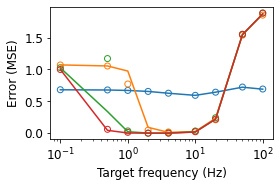

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 2.7), tight_layout=True)
for errs_ridge, errs_online, c in zip(errs_ridge_all, errs_online_all, colors):
    ax.semilogx(FRQ_TILDES, errs_ridge, c=c)
    ax.scatter(FRQ_TILDES, errs_online, edgecolors=c, facecolor='none')

set_plot(ax, x_label='Target frequency (Hz)', y_label='Error (MSE)')

fig.savefig('ms/3_lim_cyc_stats.svg')

In [8]:
N_STARS

[1, 3, 5, 11, 15]